In [2]:
from google.colab import files

fl = files.upload()



Saving irf1000.npy to irf1000.npy


In [3]:
import numpy as np

irf = np.load("irf1000.npy")

print(np.argmax(irf))

irf = irf[np.argmax(irf):]


99


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

density = 901

# Modified 29 March
def generate_gaussian():
    x = np.array(range(density))
    y = irf

    return (x,y)


# def generate_gaussian():
#     mu = np.random.uniform(low=5,high=30)
#     variance = 20
#     sigma = math.sqrt(variance)
#     x = np.linspace(mu - 3*sigma, mu + 3*sigma, 25)
#     y = stats.norm.pdf(x, mu, sigma) * np.random.uniform(low=1, high=8)


#     pref_x = np.array(range(density))
#     new_y = np.interp(pref_x,x,y)

#     new_y += np.random.uniform(low=0,high=0.1,size=(density,))

#     return (pref_x,new_y)



def f(x,a,tau):
    return a * np.exp(-x/tau)


def generate_decay_curve(amin,amax,taumin,taumax):
    a = np.random.uniform(low=amin,high=amax)
    tau = np.random.uniform(low=taumin,high=taumax)
    x = np.array(range(density))
    y = f(x,a,tau)

    return (y,a,tau)
    

def generate_dataset():
    (x,y) = generate_gaussian()
    (dec_y,a,t) = generate_decay_curve()
    z = np.convolve(y,dec_y)[:density]
    # z += np.random.uniform(0,0.2)
    z = z +  np.random.uniform(low=-z/6,high=z/6, size=density)


    input = np.concatenate((z,y))

    t = t/50
    output = (a,t)

    return (input,output)

In [5]:
def generate_dataset_three():
    (x,y) = generate_gaussian()
    
    (dec_y,a,t) = generate_decay_curve(amin=0.1,amax=1,taumin=0.1,taumax=5)
    (dec_y_2,a2,t2) = generate_decay_curve(amin=0.1,amax=1,taumin=5,taumax=15)
    (dec_y_3,a3,t3) = generate_decay_curve(amin=0.1,amax=1,taumin=15,taumax=100)

    new_dec = dec_y + dec_y_2 + dec_y_3

    t = t/5
    t2 = (t2 - 5)/10
    t3 = (t3-15)/85

    z = np.convolve(y,new_dec)[:density]
    z = z +  np.random.uniform(low=-z/6,high=z/6, size=density)

    input = np.concatenate((z,y))
    output = np.array([a,t,a2,t2,a3,t3])
    output = output.reshape(6)

    return (input,output)

In [6]:
""
x_list = []
y_list = []
for i in range(100000):
  
    (x,y) = generate_dataset_three()
  
    x_list.append(x)
    y_list.append(y)

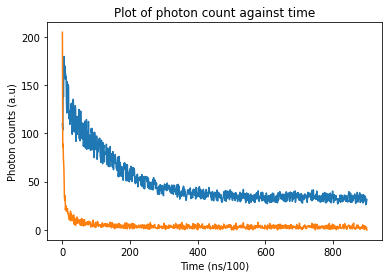

In [7]:
import matplotlib.pyplot as plt





x = np.array(range(density))
plt.plot(x,x_list[0][:density])
plt.plot(x,x_list[0][density:])
plt.xlabel("Time (ns/100)")
plt.ylabel("Photon counts (a.u)")
plt.title("Plot of photon count against time")
a = y_list[0][0]
tau = y_list[0][1]

# plt.plot(x,f(x,a,tau))
plt.show()

In [8]:
import tensorflow as tf

x_list = np.array(x_list)
y_list = np.array(y_list)

x_list = tf.keras.utils.normalize(x_list)

print(x_list.shape)
print(y_list.shape)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_list, y_list, test_size=0.10, random_state=40)




(100000, 1802)
(100000, 6)


In [9]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
import tensorflow as tf


model = Sequential()
model.add(Dense(200, activation='relu', input_dim=density*2))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(Dense(6, activation='relu'))

In [10]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-5), loss='mean_squared_error', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=128, epochs=50, validation_split=0.2)
# model.summary()

Epoch 1/50
563/563 [==============================] - 11s 18ms/step - loss: 0.1869 - accuracy: 0.1703 - val_loss: 0.0765 - val_accuracy: 0.1781
Epoch 2/50
563/563 [==============================] - 10s 17ms/step - loss: 0.0956 - accuracy: 0.1770 - val_loss: 0.0700 - val_accuracy: 0.2468
Epoch 3/50
563/563 [==============================] - 10s 18ms/step - loss: 0.0843 - accuracy: 0.2101 - val_loss: 0.0620 - val_accuracy: 0.2706
Epoch 4/50
563/563 [==============================] - 10s 18ms/step - loss: 0.0759 - accuracy: 0.2415 - val_loss: 0.0568 - val_accuracy: 0.2971
Epoch 5/50
563/563 [==============================] - 10s 17ms/step - loss: 0.0701 - accuracy: 0.2722 - val_loss: 0.0537 - val_accuracy: 0.3122
Epoch 6/50
563/563 [==============================] - 10s 17ms/step - loss: 0.0668 - accuracy: 0.2871 - val_loss: 0.0518 - val_accuracy: 0.3231
Epoch 7/50
563/563 [==============================] - 10s 17ms/step - loss: 0.0642 - accuracy: 0.2975 - val_loss: 0.0504 - val_accuracy:

In [ ]:
model.evaluate(X_test,y_test)

313/313 [==============================] - 1s 4ms/step - loss: 7.1347e-04 - accuracy: 0.9581


[0.0007134663756005466, 0.9581000208854675]

In [11]:
m_list = []
n_list = []
for i in range(50):
  (m,n) = generate_dataset_three()
  m_list.append(m)
  n_list.append(n)


m = np.array(m_list)
m = tf.keras.utils.normalize(m)
n = np.array(n_list)

# print(n_list)

In [12]:

pred_n = model.predict(m)

In [13]:
pred_n = np.array(pred_n)

Text(0.5, 1.0, 'A plot of 50 points of predicted intensity against generated\n intensity for a triple exponential decay model with fixed IRF\n where the first element has the max value')

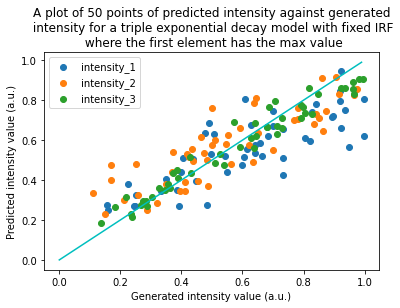

In [14]:
n_list_ = np.array(n_list).T
pred_n_ = pred_n.T

# n_list_0 = n_list_[1] * 5
# pred_n_0 = pred_n_[1] * 5

# n_list_1 = n_list_[3] * 10 + 5
# pred_n_1 = pred_n_[3] * 10 + 5

# n_list_2 = n_list_[5] * 85 + 15
# pred_n_2 = pred_n_[5] * 85 + 15


n_list_0 = n_list_[0]
pred_n_0 = pred_n_[0]

n_list_1 = n_list_[2]
pred_n_1 = pred_n_[2]

n_list_2 = n_list_[4]
pred_n_2 = pred_n_[4]


x = np.array(range(100))/100




plt.plot(x,x,c='c')
plt.scatter(n_list_0,pred_n_0,label="intensity_1")
plt.scatter(n_list_1,pred_n_1,label="intensity_2")
plt.scatter(n_list_2,pred_n_2,label="intensity_3")

plt.legend()
plt.xlabel("Generated intensity value (a.u.)")
plt.ylabel("Predicted intensity value (a.u.)")
plt.title("A plot of 50 points of predicted intensity against generated\n intensity for a triple exponential decay model with fixed IRF\n where the first element has the max value")
# # plt.show()



In [ ]:
(m,n) = generate_dataset_three()

m_norm = tf.keras.utils.normalize(m)

m_norm = np.array(m_norm)

pred_n = model.predict(m_norm)

print(pred_n)

x = np.array(range(density))
a = float(pred_n[0][0])
tau = float(pred_n[0][1])*5
a2 = float(pred_n[0][2])
tau2 = float(pred_n[0][3]) * 10 + 5
a3 = float(pred_n[0][4])
tau3 = float(pred_n[0][5]) * 85 + 15
irf = m[density:]
y = (np.convolve(irf, f(x,a,tau) + f(x,a2,tau2) + f(x,a3,tau3))[:density]
     

plt.plot(x,np.log10(irf),label="Instrument Response Function")
plt.plot(x,np.log10(m[:density]),label="Generated Impulse Response Function")
plt.plot(x,np.log10(y),label="Predicted Impulse Response Function")
plt.legend()
plt.xlabel("Time (ns/100)")
plt.ylabel("Photon count in log10(a.u)")
plt.title("Plot of photon count against time in log10 scale \n for a1= {}, a2= {}, a3= {}, t1={}ns, t2={}ns \n and t3= {} ns".format(round(a,2),round(a2,2),round(a3,2), round(tau),round(tau2),round(tau3)))
print(n)

plt.show()

SyntaxError: ignored

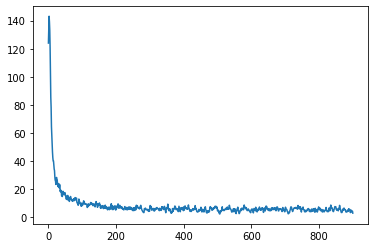

In [ ]:



y = np.convolve(irf,f(x,a,tau))[:density]

# print(y)

plt.plot(x,y)
plt.show()

In [ ]:
# n_ = 1 - (pred_n-n)/ n


# print(np.mean(n_, axis=0))

n = np.array(n_list)
pred_n_ = pred_n

# print(np.std(n,axis=0))
# print(np.std(pred_n_,axis=0))


y = 1 - np.average(np.absolute((pred_n_-n)/pred_n_),axis=0)
print(y)



[0.71277885 0.53658926 0.7440096  0.52979356 0.86481668 0.84745371]


In [ ]:
model.save("mymodel")

INFO:tensorflow:Assets written to: mymodel/assets


In [ ]:
fl = files.upload()

Saving NACL_90_1000.npy to NACL_90_1000.npy


In [ ]:
obs = np.load("NACL_90_1000.npy")[52:52+density] + 56

In [ ]:

obsdecay = np.concatenate((obs,irf))
# cc_norm = tf.keras.utils.normalize(obsdecay)
# y = model.predict(np.array(cc_norm))

# print(y)

0.36 0.31 1.18
1.3432098765432097 5.925925925925926 56.888888888888886


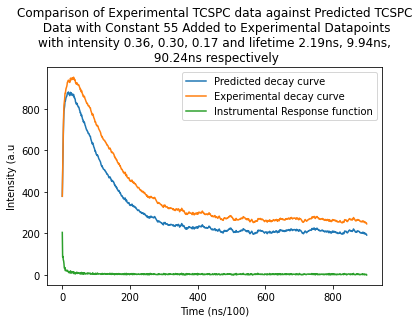

In [ ]:
a = float(y[0][0])
tau = float(y[0][1])*5
a2 = float(y[0][2])
tau2 = float(y[0][3]) * 10 + 5
a3 = float(y[0][4])
tau3 = float(pred_n[0][5]) * 85 + 15

print(a,a2,a3)
print(tau,tau2,tau3)

x = np.array(range(density))

obs = np.convolve(f(x,y[0][0],tau) + f(x,y[0][2],tau2) + f(x,y[0][4],tau3),irf)[:density]


plt.plot(x,obs, label="Predicted decay curve")
plt.plot(x, obsdecay[:density],label="Experimental decay curve")
plt.plot(x,irf,label="Instrumental Response function")
plt.title("Comparison of Experimental TCSPC data against Predicted TCSPC\n Data with Constant 55 Added to Experimental Datapoints\nwith intensity 0.36, 0.30, 0.17 and lifetime 2.19ns, 9.94ns,\n 90.24ns respectively")
plt.ylabel("Intensity (a.u")
plt.xlabel("Time (ns/100)")
plt.legend()
plt.plot()
plt.show()